In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style()

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import paired_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

Ethen 2017-09-27 21:11:40 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
matplotlib 2.0.0
sklearn 0.18.1


# Nearest Neighbors

When exploring a large set of text documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically need to convert the text document into bag of words or TF-IDF format and choose the distance metric to measure the notion of simiarity. In this documentation we'll explore the tradeoffs with representing documents using bag of words and TF-IDF.

We will be using the Wikipedia pages dataset. Each row of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase). To follow along, please download the file from this [dropbox link](https://www.dropbox.com/s/mriz0nq35ore8cr/people_wiki.csv?dl=0).

In [3]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head(3)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...


We start by converting the document into bag of words format and use this along with Euclidean distance to find the nearest neighbors of the Barack Obama.

In [4]:
# bag of words
vect = CountVectorizer()
word_weight = vect.fit_transform(wiki['text'])

# query Barack Obama's top 10 nearest neighbors
nn = NearestNeighbors(metric = 'euclidean')
nn.fit(word_weight)
obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
distances, indices = nn.kneighbors(word_weight[obama_index], n_neighbors = 10)

# 1. flatten the 2d-array distance and indices to 1d
# 2. merge the distance information with the original wiki dataset, 
#    to obtain the name matching the id.
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})
nearest_info = (wiki.
                merge(neighbors, right_on = 'id', left_index = True).
                sort_values('distance')[['id', 'name', 'distance']])
nearest_info

,id,name,distance
0,35817,Barack Obama,0.000000
1,24478,Joe Biden,33.015148
2,28447,George W. Bush,34.307434
3,14754,Mitt Romney,35.791060
4,35357,Lawrence Summers,36.069378
5,31423,Walter Mondale,36.249138
6,13229,Francisco Barrio,36.276714
7,36364,Don Bonker,36.400549
8,22745,Wynn Normington Hugh-Jones,36.441734
9,7660,Refael (Rafi) Benvenisti,36.837481


Looking at the result, it seems nice that all of the 10 people are politicians. Let's dig a bit deeper and find out why Joe Biden was considered a close neighbor of Obama by looking at the most frequently used words in both pages. To do this, we'll take the sparse row matrix that we had and extract the word count dictionary for each document.

In [5]:
def unpack_word_weight(vect, word_weight):
    """
    Given the CountVector and the fit_transformed
    word count sparse array obtain each documents' 
    word count dictionary
    
    In the Compressed Sparse Row format,
    `indices` stands for indexes inside the row vectors of the matrix 
    and `indptr` (index pointer) tells where the row starts in the data and in the indices 
    attributes. nonzero values of the i-th row are data[indptr[i]:indptr[i+1]] 
    with column indices indices[indptr[i]:indptr[i+1]]
    
    Reference
    ---------
    http://www.scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html
    """
    feature_names = np.array(vect.get_feature_names())
    data = word_weight.data
    indptr = word_weight.indptr
    indices = word_weight.indices
    n_docs = word_weight.shape[0]
    
    word_weight_list = []
    for i in range(n_docs):
        doc = slice(indptr[i], indptr[i + 1])
        count, idx = data[doc], indices[doc]
        feature = feature_names[idx]
        word_weight_dict = Counter({k: v for k, v in zip(feature, count)})
        word_weight_list.append(word_weight_dict)
    
    return word_weight_list

In [6]:
wiki['word_weight'] = unpack_word_weight(vect, word_weight)
wiki.head(3)

,URI,name,text,word_weight
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'five': 1, 'in': 13, 'during': 1, 'physical':..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'robert': 1, 'in': 4, 'mental': 1, 'day': 2, ..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'been': 1, 'cd': 1, 'in': 7, 'mainly': 1, 'st..."


In [7]:
def get_top_words(wiki, name, column_name, top_n = None):
    row = wiki.loc[wiki['name'] == name, column_name]

    # when converting Series to dictionary, the row index 
    # will be the key to the content
    word_weight_dict = row.to_dict()[row.index[0]]
    
    if top_n is None:
        top_n = len(word_weight_dict)
    
    word_weight_table = pd.DataFrame(word_weight_dict.most_common(top_n), 
                                     columns = ['word', 'weight'])
    return word_weight_table

In [8]:
words_obama = get_top_words(wiki, name = 'Barack Obama', column_name = 'word_weight')
words_biden = get_top_words(wiki, name = 'Joe Biden', column_name = 'word_weight')

# merge the two DataFrame, since both tables contained the same column name weight, 
# it will automatically renamed one of them by adding suffix _x and _y to prevent confusion.
# hence we'll rename the columns to tell which one is for which
words_combined = (words_obama.
                  merge(words_biden, on = 'word').
                  rename(columns = {'weight_x': 'Obama', 'weight_y': 'Biden'}))
words_combined.head(6)

,word,Obama,Biden
0,the,40,33
1,in,30,16
2,and,21,19
3,of,18,12
4,to,14,11
5,his,11,5


The next question we want to ask is, among these common words that appear in both documents, how many other documents in the Wikipedia dataset also contain them?

In [9]:
def has_top_words(word_weight_vector, common_words):
    """
    return True if common_words is a subset of unique_words
    return False otherwise
    
    Reference
    ---------
    http://stackoverflow.com/questions/12182744/python-pandas-apply-a-function-with-arguments-to-a-series
    """
    # extract the keys of word_weight_vector and convert it to a set
    unique_words = set(word_weight_vector.keys())
    boolean = common_words.issubset(unique_words)
    return boolean

In [10]:
# we'll extract the 5 most frequent
common_words = set(words_combined['word'].head(5))
print('top 5 common words: ', common_words)

wiki['has_top_words'] = wiki['word_weight'].apply(has_top_words, args = (common_words,))
print('number of articles that also contain the common words: ', wiki['has_top_words'].sum())

top 5 common words:  {'of', 'to', 'the', 'and', 'in'}
number of articles that also contain the common words:  56066


Give this result, we saw that much of the perceived commonalities between the two articles were due to occurrences of extremely frequent words, such as "the", "and", and "his". All of these words appear very often in all of the documents. To retrieve articles that are more relevant, maybe we should be focusing more on rare words that don't happen in every article. And this is where TF-IDF (term frequency–inverse document frequency) comes in. Note that although we can remove stop words to prevent some of this behavior, sometimes the frequently appeared words might not be a stop word.

## TF-IDF

TF-IDF, short for term frequency–inverse document frequency, is a numeric measure that is use to score the importance of a word in a document based on how often did it appear in that document and a given collection of documents. The intuition for this measure is : If a word appears frequently in a document, then it should be important and we should give that word a high score. But if a word appears in too many other documents, it’s probably not a unique identifier, therefore we should assign a lower score to that word. In short, it is a feature representation that penalizes words that are too common.

Let us consider the following toy dataset that consists of 3 documents.

In [11]:
docs = np.array([
    'The sun is shining',
    'The weather is sweet',
    'The sun is shining and the weather is sweet'
])

Most commonly, TF-IDF is calculated as follows:

$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \times \text{idf}(t, d, D)$$

Where `t` denotes the terms; `d` denotes each document; `D` denotes the collection of documents.

The first part of the formula $tf(t, d)$ stands for term frequency, which is defined by the number of times a term $t$ occurs in a document $d$.

In [12]:
vect = CountVectorizer()
tf = vect.fit_transform(docs).toarray()
tf

array([[0, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 1, 1],
       [1, 2, 1, 1, 1, 2, 1]], dtype=int64)

In [13]:
vect.vocabulary_

{'and': 0, 'is': 1, 'shining': 2, 'sun': 3, 'sweet': 4, 'the': 5, 'weather': 6}

Based on the vocabulary, the word "and" would be the first column in each document vector in `tf` and it appears once in the third document.

In order to understand the second part of the formlua $\text{idf}(t, d, D)$, inverse document frequency, let's first write down the complete math formula for IDF.

$$ idf(t, d, D) = log \frac{ \mid \text{ } D \text{ } \mid }{ 1 + \mid \{ d : t \in d \} \mid } $$

- The numerator : `D` is infering to our document space. It can also be seen as D = ${ d_{1}, d_{2}, \dots, d_{n} }$ where n is the number of documents in your collection. Thus for our example $\mid \text{ } D \text{ } \mid$, the size of our document space is 3, since we're have 3 documents
- The denominator : $\mid \{ d: t \in d \} \mid$ is the document freqency. To be explicit, it is the number of documents $d$ that contain the term $t$. Note that this implies it doesn't matter if a term appeared 1 time or 100 times in a document, it will still be counted as 1, since it simply did appear in the document
- The constant 1 is added to the denominator to avoid a zero-division error if a term is not contained in any document in the test dataset

Note that there are very different variation of the formula. For example, The tf-idfs in scikit-learn are calculated by:

$$ idf(t, d, D) = log \frac{ \mid \text{ } D \text{ } \mid }{ \mid \{ d : t \in d \} \mid } + 1 $$

Here, the `+1` count is added directly to the idf, instead of the denominator. The effect of this is that terms with zero idf, i.e. that occur in all documents of a training set, will not be entirely ignored. We can demonstrate this by calculating the idfs manually using the equation above and do the calculation ourselves and compare the results to the TfidfTransformer output using the settings `use_idf=True, smooth_idf=False, norm=None` (more on `smooth_idf` and `norm` later).

In [14]:
# compute manually the tfidf score for the first document
n_docs = len(docs)
df = np.sum(tf != 0, axis = 0)
idf = np.log(n_docs / df) + 1
tf_idf = tf[0] * idf
print(tf_idf)
print()

# use the library to do the computation
tfidf = TfidfTransformer(use_idf = True, smooth_idf = False, norm = None)
doc_tfidf = tfidf.fit_transform(tf).toarray()
print(doc_tfidf[0])

assert np.allclose(tf_idf, doc_tfidf[0])

[ 0.          1.          1.40546511  1.40546511  0.          1.          0.        ]

[ 0.          1.          1.40546511  1.40546511  0.          1.          0.        ]


Next, recall that in the tf (term frequency) section, we’re representing each term as the number of times they appeared in the document. The main issue for this representation is that it will create a bias towards long documents, as a given term has more chance to appear in longer document, making them look more important than actually they are. Thus the approach to resolve this issue is the good old L2 normalization. i.e., dividing the raw term frequency vector $v$ by its length $||v||_2$ (L2- or Euclidean norm).

$$v_{norm} = \frac{v}{ \parallel v \parallel_2} = \frac{v}{\sqrt{v{_1}^2 + v{_2}^2 + \dots + v{_n}^2}} = \frac{v}{\big(\sum_{i=1}^n v_i^2 \big)^{\frac{1}{2}}}$$

In [15]:
# manual
tf_norm = tf_idf / np.sqrt(np.sum(tf_idf ** 2))
print(tf_norm)
print()

# library
tfidf = TfidfTransformer(use_idf = True, smooth_idf = False, norm = 'l2')
doc_tfidf = tfidf.fit_transform(tf).toarray()
print(doc_tfidf[0])

assert np.allclose(tf_norm, doc_tfidf[0])

[ 0.          0.40993715  0.57615236  0.57615236  0.          0.40993715
  0.        ]

[ 0.          0.40993715  0.57615236  0.57615236  0.          0.40993715
  0.        ]


Another parameter in the `TfidfTransformer` is the `smooth_idf`, which is described as

> smooth_idf : boolean, default=True  
Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.

So, our idf would then be defined as follows:

$$idf(t, d, D) = log \frac{ 1 + \mid D \text{ } \mid }{ 1 + \mid \{ d : t \in d \} \mid } + 1 $$ 

Again let's confirm this by computing it manually and using the library.

In [16]:
# manual
n_docs = len(docs)
df = np.sum(tf != 0, axis = 0)
idf = np.log((1 + n_docs) / (1 + df)) + 1
tf_idf = tf[0] * idf
tf_norm = tf_idf / np.sqrt(np.sum(tf_idf ** 2))
print(tf_norm)
print()

# library
tfidf = TfidfTransformer(use_idf = True, smooth_idf = True, norm = 'l2')
doc_tfidf = tfidf.fit_transform(tf).toarray()
print(doc_tfidf[0])

assert np.allclose(tf_norm, doc_tfidf[0])

[ 0.          0.43370786  0.55847784  0.55847784  0.          0.43370786
  0.        ]

[ 0.          0.43370786  0.55847784  0.55847784  0.          0.43370786
  0.        ]


To sum up, the default settings in the `TfidfTransformer` is:

- `use_idf=True`
- `smooth_idf=True`
- `norm='l2'`

And we can use the `TfidfVectorizer` to compute the TF-IDF score from raw text in one step without having to do use `CountVectorizer` to convert it to bag of words representation and then transform it to TF-IDF using `TfidfTransformer`.

Now that we've understood the inner details on TF-IDF let's return back to our initial task and use this weighting scheme instead of bag of words. We start by converting the document into TF-IDF format and use this along with cosine distance to find the nearest neighbors of the Barack Obama (if we normalized our articles in the TF-IDF transformation, then the euclidean distance and the cosine distance is proportional to each other, hence they're doing the same thing). Then we extract the commonly used words (now weighted by the TF-IDF score instead of word count) in both the Joe Biden and Obama article. Finally we compute how many other documents in the Wikipedia dataset also contain these words. In short, we're doing the exact same thing as the beginning except we now use TF-IDF to represent the documents and use cosine distance to measure similarity between documents.

In [17]:
# tf-idf instead of bag of words
tfidf_vect = TfidfVectorizer()
tfidf_weight = tfidf_vect.fit_transform(wiki['text'])

# this time, query Barack Obama's top 100 nearest neighbors using
# cosine distance, we have to specify the algorithm to `brute` since
# the default 'auto' does not work with cosine distance
# http://stackoverflow.com/questions/32745541/dbscan-error-with-cosine-metric-in-python
nn_cosine = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
nn_cosine.fit(tfidf_weight)
obama_index = wiki[wiki['name'] == 'Barack Obama'].index[0]
cosine, indices = nn_cosine.kneighbors(tfidf_weight[obama_index], n_neighbors = 100)

# 1. flatten the 2d-array distance and indices to 1d
# 2. merge the distance information with the original wiki dataset, 
#    to obtain the name matching the id.
neighbors_cosine = pd.DataFrame({'cosine': cosine.flatten(), 'id': indices.flatten()})
nearest_info = (wiki.
                merge(neighbors_cosine, right_on = 'id', left_index = True).
                sort_values('cosine')[['id', 'name', 'cosine']])

nearest_info.head()

,id,name,cosine
0,35817,Barack Obama,0.000000
1,24478,Joe Biden,0.570781
2,57108,Hillary Rodham Clinton,0.615934
3,38376,Samantha Power,0.624993
4,38714,Eric Stern (politician),0.649765


In [18]:
wiki['tfidf_weight'] = unpack_word_weight(tfidf_vect, tfidf_weight)
wiki.head(3)

,URI,name,text,word_weight,has_top_words,tfidf_weight
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'five': 1, 'in': 13, 'during': 1, 'physical':...",True,"{'five': 0.0324788845439, 'in': 0.131514231341..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'robert': 1, 'in': 4, 'mental': 1, 'day': 2, ...",True,"{'available': 0.0440139597152, 'in': 0.0356301..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'been': 1, 'cd': 1, 'in': 7, 'mainly': 1, 'st...",True,"{'been': 0.0229165351874, 'cd': 0.055259939814..."


In [19]:
words_obama = get_top_words(wiki, name = 'Barack Obama', column_name = 'tfidf_weight')
words_biden = get_top_words(wiki, name = 'Joe Biden', column_name = 'tfidf_weight')

words_combined = (words_obama.
                  merge(words_biden, on = 'word').
                  rename(columns = {'weight_x': 'Obama', 'weight_y': 'Biden'}))
words_combined.head(6)

,word,Obama,Biden
0,obama,0.365018,0.174794
1,the,0.279323,0.248287
2,act,0.249089,0.167737
3,in,0.209673,0.120486
4,iraq,0.151809,0.040891
5,and,0.146739,0.143045


In [20]:
# we'll extract the 5 most frequent
common_words = set(words_combined['word'].head(5))
print( 'top 5 common words: ', common_words )

wiki['has_top_words'] = wiki['tfidf_weight'].apply(has_top_words, args = (common_words,))
print('number of articles that also contain the common words: ', wiki['has_top_words'].sum())

top 5 common words:  {'act', 'iraq', 'the', 'in', 'obama'}
number of articles that also contain the common words:  5


Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words. Happily ever after? Not so fast. To illustrate another possible issue, let's first compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [21]:
def compute_length(row):
    return len(row.split(' '))


wiki['length'] = wiki['text'].apply(compute_length) 
wiki.head(3)

,URI,name,text,word_weight,has_top_words,tfidf_weight,length
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'five': 1, 'in': 13, 'during': 1, 'physical':...",False,"{'five': 0.0324788845439, 'in': 0.131514231341...",251
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'robert': 1, 'in': 4, 'mental': 1, 'day': 2, ...",False,"{'available': 0.0440139597152, 'in': 0.0356301...",223
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'been': 1, 'cd': 1, 'in': 7, 'mainly': 1, 'st...",False,"{'been': 0.0229165351874, 'cd': 0.055259939814...",226


In [22]:
nearest_cosine = (wiki.
                  merge(neighbors_cosine, right_on = 'id', left_index = True).
                  sort_values('cosine')[['id', 'name', 'cosine', 'length']])

nearest_cosine.head()

,id,name,cosine,length
0,35817,Barack Obama,0.000000,540
1,24478,Joe Biden,0.570781,414
2,57108,Hillary Rodham Clinton,0.615934,580
3,38376,Samantha Power,0.624993,310
4,38714,Eric Stern (politician),0.649765,255


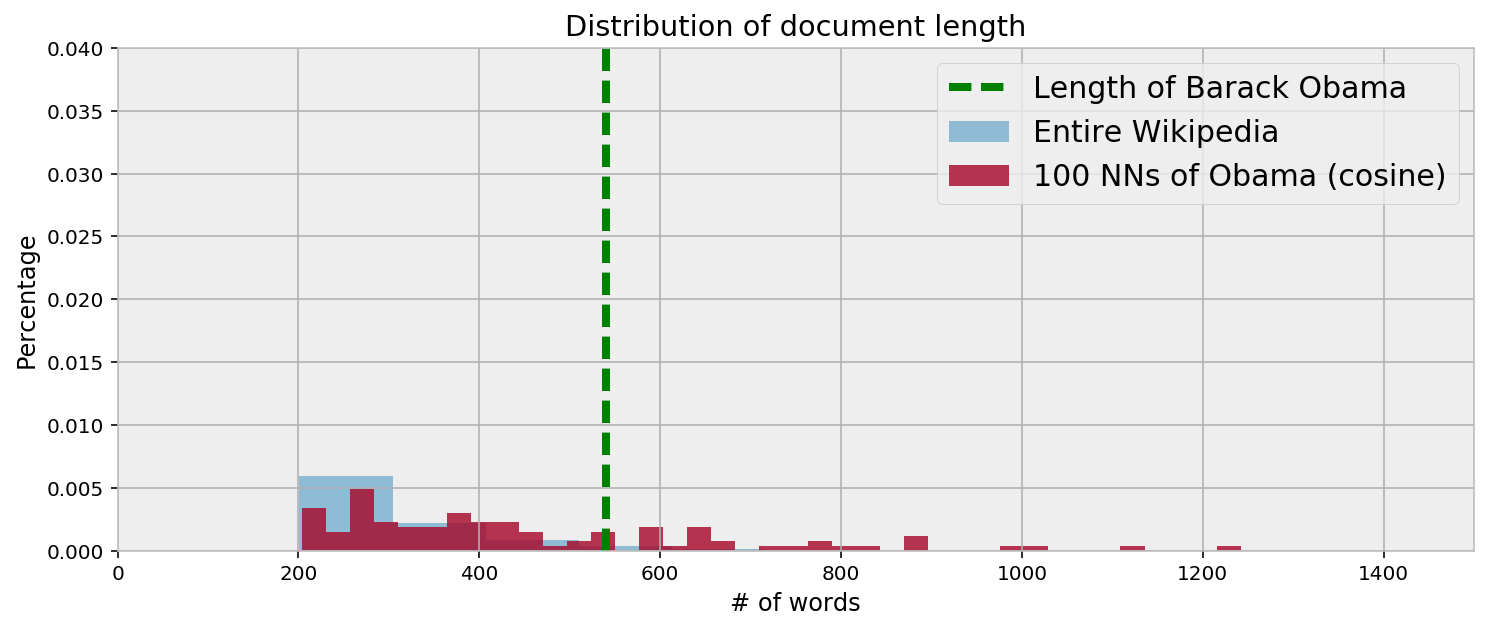

In [23]:
plt.figure(figsize = (10.5, 4.5))
plt.hist(wiki['length'], 50, histtype = 'stepfilled', 
         normed = True, label = 'Entire Wikipedia', alpha = 0.5)

plt.hist(nearest_cosine['length'], 50, histtype = 'stepfilled', 
         normed = True, label = '100 NNs of Obama (cosine)', alpha = 0.8)

plt.axvline(nearest_cosine.loc[nearest_cosine['name'] == 'Barack Obama', 'length'].values, 
            color = 'g', linestyle = '--', linewidth = 4,
            label = 'Length of Barack Obama')

plt.axis([0, 1500, 0, 0.04])
plt.legend(loc = 'best', prop = {'size': 15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.tight_layout()

The visualization is basically telling us that 100 nearest neighbors using TF-IDF weighting and cosine distance provide a sampling across articles with different length. The thing is that whether we're choosing euclidean or cosine distance to measure our articles' similarity, both of them still ignore the document's length, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) tweet.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features; compute the cosine distance between the Barack Obama article and this tweet and compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors.

In [24]:
tweet = tfidf_vect.transform(['democratic governments control law in response to popular act'])
tweet_dist = paired_distances(tfidf_weight[obama_index], tweet, metric = 'cosine')

# compare to the 100 articles that were nearest to Obama's,
# the distance of this tweet is shorter than how many articles
np.sum(tweet_dist < nearest_cosine['cosine'].values)

79

With cosine distances, the tweet is "nearer" to Barack Obama than most of the articles. If someone is reading the Barack Obama Wikipedia page, would we want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from *The Atlantic*, we wouldn't recommend him/her a tweet.

# Reference

- [Coursera: Washington Clustering & Retrieval](https://www.coursera.org/learn/ml-clustering-and-retrieval)
- [Notebooks: Tf-idf Walkthrough for scikit-learn](http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/tfidf_scikit-learn.ipynb)
- [Blog: Machine Learning :: Text feature extraction (tf-idf)](http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/)